# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper
helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

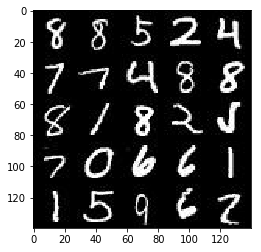

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

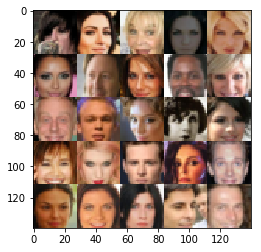

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    inputs_real = tf.placeholder(tf.float32, 
                                 (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=[])    

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [70]:
def discriminator(images, reuse=False, alpha=.2, drop_rate=.1 ):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :param alpha: Leaky p.. (I added this)
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 56, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        relu1 = tf.layers.dropout(relu1, rate=drop_rate)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 112, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 224, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.layers.dropout(relu3, rate=drop_rate)
        # 4x4x256
    

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*224))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
       
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [71]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :param reuse:
    :param alpha
    :return: The tensor output of the generator
    """
    
    
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        
        x0 = tf.layers.dense(z, 4*4*448)
        # Reshape it to start the convolutional stack
        x0 = tf.reshape(x0, (-1, 4, 4, 448))
        x0 = tf.layers.batch_normalization(x0, training=is_train)
        x0 = tf.maximum(alpha * x0, x0)
        
 
        # Reshape it to start the convolutional stack
        x1 = tf.layers.conv2d_transpose(x0, 224, 4, strides=1, padding='valid')
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x448 now
        
        x2 = tf.layers.conv2d_transpose(x1, 112, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x224 now
        
        x3 = tf.layers.conv2d_transpose(x2, 56, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 32x32x3 now
        #logits = tf.reshape(logits, (None, 28, 28, out_channel_dim))
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [72]:
def model_loss(input_real, input_z, out_channel_dim, alpha=.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [73]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
        
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [74]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [75]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
        
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z,
                                              data_shape[3], alpha=.2)
    
    
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0 #For counting batches
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                batch_images = batch_images*2
                
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % 10 == 0:  #Print output every 10
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:   #Show example every 100
                    show_generator_output(sess, 9, input_z, data_shape[3], image_mode=data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.6308... Generator Loss: 0.4469
Epoch 1/2... Discriminator Loss: 1.0935... Generator Loss: 0.7991
Epoch 1/2... Discriminator Loss: 1.1299... Generator Loss: 0.6452
Epoch 1/2... Discriminator Loss: 1.2002... Generator Loss: 0.9996
Epoch 1/2... Discriminator Loss: 1.5953... Generator Loss: 1.4378
Epoch 1/2... Discriminator Loss: 0.6916... Generator Loss: 1.7627
Epoch 1/2... Discriminator Loss: 0.5769... Generator Loss: 1.4256
Epoch 1/2... Discriminator Loss: 0.5263... Generator Loss: 1.6407
Epoch 1/2... Discriminator Loss: 0.6602... Generator Loss: 1.2819
Epoch 1/2... Discriminator Loss: 0.6209... Generator Loss: 1.6464


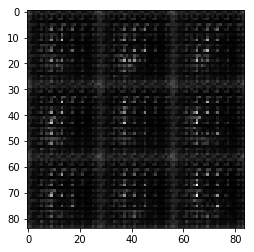

Epoch 1/2... Discriminator Loss: 1.0684... Generator Loss: 0.9337
Epoch 1/2... Discriminator Loss: 1.4074... Generator Loss: 0.7012
Epoch 1/2... Discriminator Loss: 0.9478... Generator Loss: 1.0562
Epoch 1/2... Discriminator Loss: 0.7943... Generator Loss: 1.4295
Epoch 1/2... Discriminator Loss: 0.8889... Generator Loss: 1.0699
Epoch 1/2... Discriminator Loss: 1.1409... Generator Loss: 1.0779
Epoch 1/2... Discriminator Loss: 1.1361... Generator Loss: 1.0485
Epoch 1/2... Discriminator Loss: 0.8736... Generator Loss: 1.4303
Epoch 1/2... Discriminator Loss: 0.9447... Generator Loss: 1.0874
Epoch 1/2... Discriminator Loss: 0.9292... Generator Loss: 1.2335


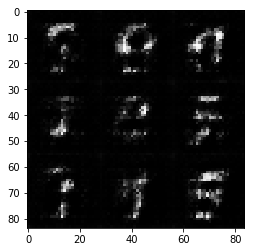

Epoch 1/2... Discriminator Loss: 1.2751... Generator Loss: 0.8917
Epoch 1/2... Discriminator Loss: 1.3056... Generator Loss: 0.9181
Epoch 1/2... Discriminator Loss: 1.0149... Generator Loss: 1.0802
Epoch 1/2... Discriminator Loss: 1.0452... Generator Loss: 0.9862
Epoch 1/2... Discriminator Loss: 0.8859... Generator Loss: 1.0825
Epoch 1/2... Discriminator Loss: 0.8427... Generator Loss: 1.0573
Epoch 1/2... Discriminator Loss: 0.8500... Generator Loss: 1.4886
Epoch 1/2... Discriminator Loss: 0.9443... Generator Loss: 1.1418
Epoch 1/2... Discriminator Loss: 1.0317... Generator Loss: 1.2911
Epoch 1/2... Discriminator Loss: 0.9704... Generator Loss: 1.1637


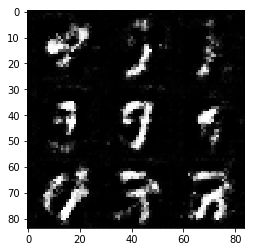

Epoch 1/2... Discriminator Loss: 1.1921... Generator Loss: 0.5097
Epoch 1/2... Discriminator Loss: 0.6991... Generator Loss: 1.3978
Epoch 1/2... Discriminator Loss: 0.9135... Generator Loss: 1.1286
Epoch 1/2... Discriminator Loss: 0.8946... Generator Loss: 1.0569
Epoch 1/2... Discriminator Loss: 0.9249... Generator Loss: 1.4284
Epoch 1/2... Discriminator Loss: 1.1028... Generator Loss: 1.7339
Epoch 1/2... Discriminator Loss: 0.7759... Generator Loss: 1.4234
Epoch 1/2... Discriminator Loss: 0.8739... Generator Loss: 0.8517
Epoch 1/2... Discriminator Loss: 0.8814... Generator Loss: 0.8520
Epoch 1/2... Discriminator Loss: 0.8654... Generator Loss: 0.7513


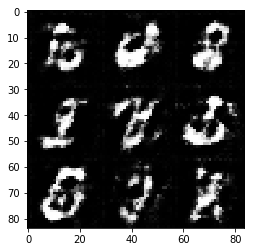

Epoch 1/2... Discriminator Loss: 0.8754... Generator Loss: 1.0620
Epoch 1/2... Discriminator Loss: 0.8707... Generator Loss: 1.7174
Epoch 1/2... Discriminator Loss: 0.8591... Generator Loss: 1.4738
Epoch 1/2... Discriminator Loss: 0.7963... Generator Loss: 1.4428
Epoch 1/2... Discriminator Loss: 0.8276... Generator Loss: 1.0041
Epoch 1/2... Discriminator Loss: 0.7862... Generator Loss: 0.9592
Epoch 1/2... Discriminator Loss: 0.7788... Generator Loss: 1.0201
Epoch 1/2... Discriminator Loss: 0.8625... Generator Loss: 1.6440
Epoch 1/2... Discriminator Loss: 0.8629... Generator Loss: 1.9743
Epoch 1/2... Discriminator Loss: 0.8288... Generator Loss: 0.9056


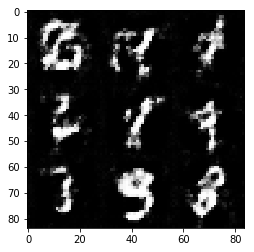

Epoch 1/2... Discriminator Loss: 0.8475... Generator Loss: 1.6546
Epoch 1/2... Discriminator Loss: 0.9085... Generator Loss: 0.8450
Epoch 1/2... Discriminator Loss: 0.8079... Generator Loss: 0.9981
Epoch 1/2... Discriminator Loss: 1.0258... Generator Loss: 1.0096
Epoch 1/2... Discriminator Loss: 1.0919... Generator Loss: 0.6014
Epoch 1/2... Discriminator Loss: 0.9594... Generator Loss: 0.9884
Epoch 1/2... Discriminator Loss: 1.0846... Generator Loss: 0.6068
Epoch 1/2... Discriminator Loss: 1.0743... Generator Loss: 1.5413
Epoch 1/2... Discriminator Loss: 1.1018... Generator Loss: 1.6431
Epoch 1/2... Discriminator Loss: 0.9985... Generator Loss: 1.4532


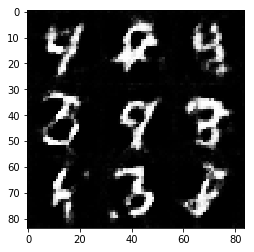

Epoch 2/2... Discriminator Loss: 1.0625... Generator Loss: 0.7897
Epoch 2/2... Discriminator Loss: 0.9956... Generator Loss: 0.9703
Epoch 2/2... Discriminator Loss: 0.9882... Generator Loss: 1.0370
Epoch 2/2... Discriminator Loss: 1.2129... Generator Loss: 0.5086
Epoch 2/2... Discriminator Loss: 0.9968... Generator Loss: 1.1505
Epoch 2/2... Discriminator Loss: 1.0187... Generator Loss: 0.9141
Epoch 2/2... Discriminator Loss: 0.9716... Generator Loss: 1.2421
Epoch 2/2... Discriminator Loss: 0.9188... Generator Loss: 1.4539
Epoch 2/2... Discriminator Loss: 0.9748... Generator Loss: 0.8332
Epoch 2/2... Discriminator Loss: 1.1464... Generator Loss: 1.6567


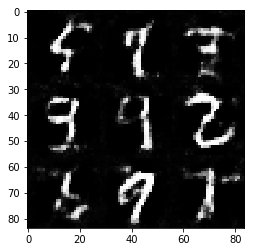

Epoch 2/2... Discriminator Loss: 0.9442... Generator Loss: 0.9144
Epoch 2/2... Discriminator Loss: 1.3205... Generator Loss: 1.9824
Epoch 2/2... Discriminator Loss: 1.0021... Generator Loss: 0.9006
Epoch 2/2... Discriminator Loss: 0.9822... Generator Loss: 0.8942
Epoch 2/2... Discriminator Loss: 0.9823... Generator Loss: 0.7864
Epoch 2/2... Discriminator Loss: 1.0714... Generator Loss: 0.7293
Epoch 2/2... Discriminator Loss: 0.8911... Generator Loss: 0.9558
Epoch 2/2... Discriminator Loss: 1.0191... Generator Loss: 0.7556
Epoch 2/2... Discriminator Loss: 0.9986... Generator Loss: 1.3496
Epoch 2/2... Discriminator Loss: 1.0327... Generator Loss: 1.5481


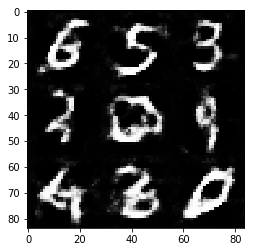

Epoch 2/2... Discriminator Loss: 0.9813... Generator Loss: 0.8989
Epoch 2/2... Discriminator Loss: 1.1098... Generator Loss: 0.5929
Epoch 2/2... Discriminator Loss: 0.8815... Generator Loss: 1.2970
Epoch 2/2... Discriminator Loss: 0.9109... Generator Loss: 0.9234
Epoch 2/2... Discriminator Loss: 0.9597... Generator Loss: 1.0578
Epoch 2/2... Discriminator Loss: 1.3617... Generator Loss: 0.4086
Epoch 2/2... Discriminator Loss: 0.9047... Generator Loss: 1.2408
Epoch 2/2... Discriminator Loss: 0.9141... Generator Loss: 1.0939
Epoch 2/2... Discriminator Loss: 0.9103... Generator Loss: 1.0634
Epoch 2/2... Discriminator Loss: 1.2192... Generator Loss: 1.8097


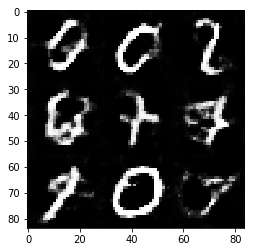

Epoch 2/2... Discriminator Loss: 1.0600... Generator Loss: 1.2707
Epoch 2/2... Discriminator Loss: 0.9104... Generator Loss: 1.0374
Epoch 2/2... Discriminator Loss: 1.3994... Generator Loss: 1.8813
Epoch 2/2... Discriminator Loss: 0.8863... Generator Loss: 0.8943
Epoch 2/2... Discriminator Loss: 0.9806... Generator Loss: 1.1212
Epoch 2/2... Discriminator Loss: 0.9764... Generator Loss: 1.2158
Epoch 2/2... Discriminator Loss: 0.8872... Generator Loss: 0.9942
Epoch 2/2... Discriminator Loss: 1.1889... Generator Loss: 0.4962
Epoch 2/2... Discriminator Loss: 0.8955... Generator Loss: 1.0210
Epoch 2/2... Discriminator Loss: 0.8903... Generator Loss: 0.8371


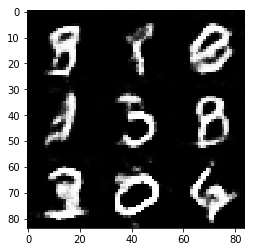

Epoch 2/2... Discriminator Loss: 0.8870... Generator Loss: 1.0886
Epoch 2/2... Discriminator Loss: 0.9904... Generator Loss: 0.7818
Epoch 2/2... Discriminator Loss: 1.0365... Generator Loss: 0.6852
Epoch 2/2... Discriminator Loss: 0.9174... Generator Loss: 1.3575
Epoch 2/2... Discriminator Loss: 1.2960... Generator Loss: 0.4281
Epoch 2/2... Discriminator Loss: 1.1046... Generator Loss: 1.4098
Epoch 2/2... Discriminator Loss: 1.2947... Generator Loss: 0.4348
Epoch 2/2... Discriminator Loss: 0.9136... Generator Loss: 1.2750
Epoch 2/2... Discriminator Loss: 0.8680... Generator Loss: 1.0949
Epoch 2/2... Discriminator Loss: 0.9303... Generator Loss: 0.8253


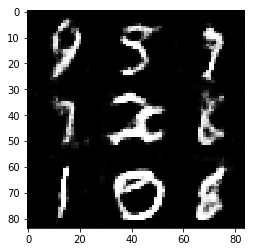

Epoch 2/2... Discriminator Loss: 0.9578... Generator Loss: 1.1389
Epoch 2/2... Discriminator Loss: 0.8074... Generator Loss: 1.2361
Epoch 2/2... Discriminator Loss: 1.0406... Generator Loss: 0.6355
Epoch 2/2... Discriminator Loss: 1.0562... Generator Loss: 0.6493
Epoch 2/2... Discriminator Loss: 0.8999... Generator Loss: 1.0405
Epoch 2/2... Discriminator Loss: 0.9358... Generator Loss: 1.6512
Epoch 2/2... Discriminator Loss: 0.9204... Generator Loss: 0.8615
Epoch 2/2... Discriminator Loss: 0.9211... Generator Loss: 0.7938
Epoch 2/2... Discriminator Loss: 0.9227... Generator Loss: 0.9961
Epoch 2/2... Discriminator Loss: 1.1365... Generator Loss: 1.6150


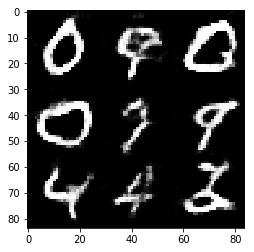

In [88]:
batch_size = 100
z_dim = 60
learning_rate = .0001
beta1 = .5

# In the paper they used  
# Weight initialization from Zero-centered normal with std of .02

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.5890
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 0.9598
Epoch 1/1... Discriminator Loss: 0.9738... Generator Loss: 0.9366
Epoch 1/1... Discriminator Loss: 0.8969... Generator Loss: 1.0494
Epoch 1/1... Discriminator Loss: 0.6172... Generator Loss: 1.4859
Epoch 1/1... Discriminator Loss: 0.3452... Generator Loss: 2.1947
Epoch 1/1... Discriminator Loss: 0.4263... Generator Loss: 1.8700
Epoch 1/1... Discriminator Loss: 0.3432... Generator Loss: 2.0900
Epoch 1/1... Discriminator Loss: 0.3229... Generator Loss: 2.0131
Epoch 1/1... Discriminator Loss: 0.3257... Generator Loss: 1.9643


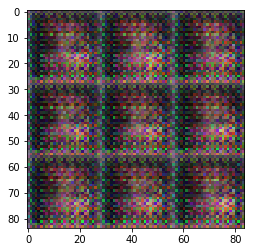

Epoch 1/1... Discriminator Loss: 0.2578... Generator Loss: 2.2946
Epoch 1/1... Discriminator Loss: 0.4646... Generator Loss: 1.5846
Epoch 1/1... Discriminator Loss: 0.1903... Generator Loss: 2.5127
Epoch 1/1... Discriminator Loss: 0.3006... Generator Loss: 1.7736
Epoch 1/1... Discriminator Loss: 0.4067... Generator Loss: 1.7094
Epoch 1/1... Discriminator Loss: 0.1181... Generator Loss: 3.0110
Epoch 1/1... Discriminator Loss: 0.1881... Generator Loss: 2.5911
Epoch 1/1... Discriminator Loss: 0.1470... Generator Loss: 2.7744
Epoch 1/1... Discriminator Loss: 0.1096... Generator Loss: 2.9995
Epoch 1/1... Discriminator Loss: 0.1450... Generator Loss: 2.8821


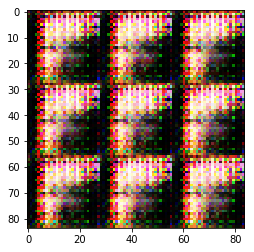

Epoch 1/1... Discriminator Loss: 0.1576... Generator Loss: 2.7921
Epoch 1/1... Discriminator Loss: 0.1298... Generator Loss: 2.5664
Epoch 1/1... Discriminator Loss: 0.1021... Generator Loss: 3.1960
Epoch 1/1... Discriminator Loss: 0.0875... Generator Loss: 3.1409
Epoch 1/1... Discriminator Loss: 0.1092... Generator Loss: 2.8896
Epoch 1/1... Discriminator Loss: 0.0929... Generator Loss: 3.0922
Epoch 1/1... Discriminator Loss: 0.1380... Generator Loss: 2.7541
Epoch 1/1... Discriminator Loss: 0.3015... Generator Loss: 1.7285
Epoch 1/1... Discriminator Loss: 0.1217... Generator Loss: 2.3357
Epoch 1/1... Discriminator Loss: 0.0963... Generator Loss: 3.2178


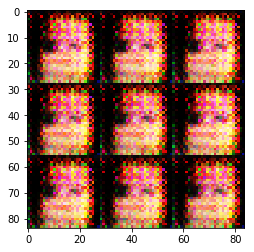

Epoch 1/1... Discriminator Loss: 0.0841... Generator Loss: 3.6031
Epoch 1/1... Discriminator Loss: 0.0503... Generator Loss: 3.4627
Epoch 1/1... Discriminator Loss: 0.0849... Generator Loss: 3.4996
Epoch 1/1... Discriminator Loss: 0.2235... Generator Loss: 2.2952
Epoch 1/1... Discriminator Loss: 0.0956... Generator Loss: 5.4842
Epoch 1/1... Discriminator Loss: 0.0397... Generator Loss: 3.7018
Epoch 1/1... Discriminator Loss: 0.1185... Generator Loss: 2.9169
Epoch 1/1... Discriminator Loss: 0.1091... Generator Loss: 2.8792
Epoch 1/1... Discriminator Loss: 0.1938... Generator Loss: 2.4018
Epoch 1/1... Discriminator Loss: 0.1067... Generator Loss: 2.5524


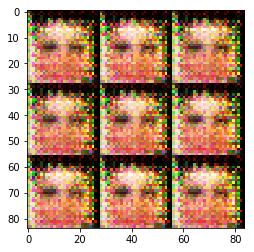

Epoch 1/1... Discriminator Loss: 0.0668... Generator Loss: 3.4619
Epoch 1/1... Discriminator Loss: 0.0780... Generator Loss: 3.4144
Epoch 1/1... Discriminator Loss: 0.0526... Generator Loss: 3.5724
Epoch 1/1... Discriminator Loss: 0.0422... Generator Loss: 3.6914
Epoch 1/1... Discriminator Loss: 0.0579... Generator Loss: 3.3858
Epoch 1/1... Discriminator Loss: 0.1095... Generator Loss: 2.9337
Epoch 1/1... Discriminator Loss: 0.0403... Generator Loss: 4.9910
Epoch 1/1... Discriminator Loss: 0.0524... Generator Loss: 3.7704
Epoch 1/1... Discriminator Loss: 0.0383... Generator Loss: 4.1903
Epoch 1/1... Discriminator Loss: 0.1031... Generator Loss: 3.7161


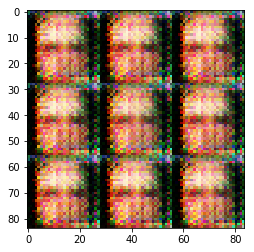

Epoch 1/1... Discriminator Loss: 0.0884... Generator Loss: 3.0584
Epoch 1/1... Discriminator Loss: 0.0700... Generator Loss: 3.6781
Epoch 1/1... Discriminator Loss: 0.0199... Generator Loss: 4.5804
Epoch 1/1... Discriminator Loss: 0.0461... Generator Loss: 3.8320
Epoch 1/1... Discriminator Loss: 0.0847... Generator Loss: 3.0644
Epoch 1/1... Discriminator Loss: 0.0693... Generator Loss: 3.3870
Epoch 1/1... Discriminator Loss: 0.0617... Generator Loss: 3.6491
Epoch 1/1... Discriminator Loss: 0.0493... Generator Loss: 4.3905
Epoch 1/1... Discriminator Loss: 0.0232... Generator Loss: 5.1653
Epoch 1/1... Discriminator Loss: 0.1140... Generator Loss: 3.2826


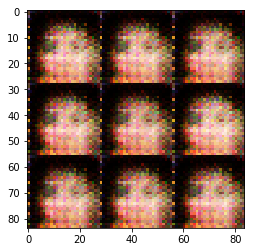

Epoch 1/1... Discriminator Loss: 0.2288... Generator Loss: 16.7938
Epoch 1/1... Discriminator Loss: 1.1336... Generator Loss: 16.1864
Epoch 1/1... Discriminator Loss: 0.0926... Generator Loss: 2.6581
Epoch 1/1... Discriminator Loss: 0.1549... Generator Loss: 2.8378
Epoch 1/1... Discriminator Loss: 0.0918... Generator Loss: 3.0973
Epoch 1/1... Discriminator Loss: 0.4170... Generator Loss: 1.7570
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 5.8939
Epoch 1/1... Discriminator Loss: 0.5244... Generator Loss: 1.5268
Epoch 1/1... Discriminator Loss: 0.3741... Generator Loss: 2.4700
Epoch 1/1... Discriminator Loss: 0.4120... Generator Loss: 1.5696


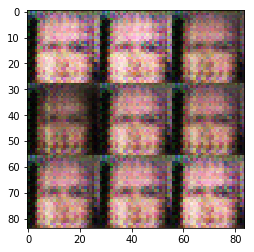

Epoch 1/1... Discriminator Loss: 0.1827... Generator Loss: 2.6889
Epoch 1/1... Discriminator Loss: 0.2819... Generator Loss: 1.8696
Epoch 1/1... Discriminator Loss: 0.9352... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 0.2830... Generator Loss: 2.1502
Epoch 1/1... Discriminator Loss: 0.9688... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 0.4072... Generator Loss: 2.2712
Epoch 1/1... Discriminator Loss: 0.6636... Generator Loss: 1.2606
Epoch 1/1... Discriminator Loss: 0.5829... Generator Loss: 1.8678
Epoch 1/1... Discriminator Loss: 0.7360... Generator Loss: 0.9359
Epoch 1/1... Discriminator Loss: 0.8178... Generator Loss: 1.0497


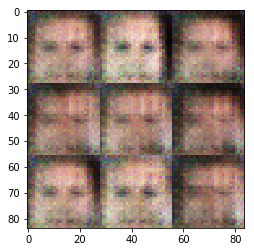

Epoch 1/1... Discriminator Loss: 0.6675... Generator Loss: 1.3512
Epoch 1/1... Discriminator Loss: 0.5661... Generator Loss: 1.2868
Epoch 1/1... Discriminator Loss: 0.5751... Generator Loss: 1.6519
Epoch 1/1... Discriminator Loss: 0.7257... Generator Loss: 1.1610
Epoch 1/1... Discriminator Loss: 0.5947... Generator Loss: 1.5576
Epoch 1/1... Discriminator Loss: 0.6168... Generator Loss: 1.4864
Epoch 1/1... Discriminator Loss: 0.9361... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 1.1935
Epoch 1/1... Discriminator Loss: 0.8383... Generator Loss: 1.1850
Epoch 1/1... Discriminator Loss: 0.9823... Generator Loss: 0.7467


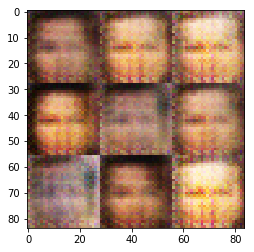

Epoch 1/1... Discriminator Loss: 0.6132... Generator Loss: 1.8640
Epoch 1/1... Discriminator Loss: 0.5283... Generator Loss: 1.5428
Epoch 1/1... Discriminator Loss: 0.7106... Generator Loss: 1.2166
Epoch 1/1... Discriminator Loss: 0.5952... Generator Loss: 1.5607
Epoch 1/1... Discriminator Loss: 0.9841... Generator Loss: 1.2165
Epoch 1/1... Discriminator Loss: 0.8181... Generator Loss: 1.1431
Epoch 1/1... Discriminator Loss: 0.8853... Generator Loss: 1.7711
Epoch 1/1... Discriminator Loss: 0.6050... Generator Loss: 1.3650
Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 1.6936
Epoch 1/1... Discriminator Loss: 0.9199... Generator Loss: 2.1738


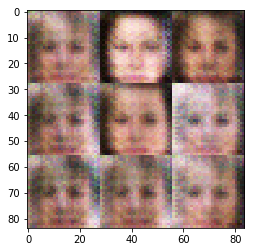

Epoch 1/1... Discriminator Loss: 0.5316... Generator Loss: 1.5642
Epoch 1/1... Discriminator Loss: 0.6712... Generator Loss: 1.4690
Epoch 1/1... Discriminator Loss: 0.6024... Generator Loss: 1.3192
Epoch 1/1... Discriminator Loss: 0.6644... Generator Loss: 1.5951
Epoch 1/1... Discriminator Loss: 0.5323... Generator Loss: 2.0479
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 1.6467
Epoch 1/1... Discriminator Loss: 0.6473... Generator Loss: 1.9204
Epoch 1/1... Discriminator Loss: 0.9297... Generator Loss: 1.2175
Epoch 1/1... Discriminator Loss: 0.8640... Generator Loss: 1.4143
Epoch 1/1... Discriminator Loss: 0.6578... Generator Loss: 2.1883


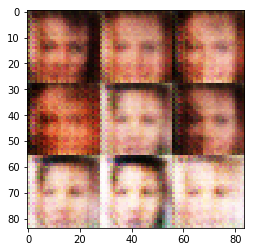

Epoch 1/1... Discriminator Loss: 0.6527... Generator Loss: 1.8551
Epoch 1/1... Discriminator Loss: 0.7518... Generator Loss: 1.2984
Epoch 1/1... Discriminator Loss: 0.8076... Generator Loss: 2.2369
Epoch 1/1... Discriminator Loss: 0.6088... Generator Loss: 1.5286
Epoch 1/1... Discriminator Loss: 0.5447... Generator Loss: 1.4942
Epoch 1/1... Discriminator Loss: 0.7720... Generator Loss: 2.3049
Epoch 1/1... Discriminator Loss: 0.8272... Generator Loss: 1.6734
Epoch 1/1... Discriminator Loss: 0.6934... Generator Loss: 1.4111
Epoch 1/1... Discriminator Loss: 0.7810... Generator Loss: 0.9840
Epoch 1/1... Discriminator Loss: 0.9136... Generator Loss: 1.0451


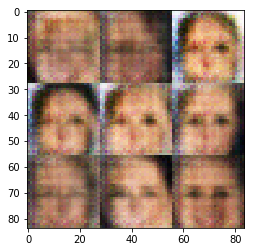

Epoch 1/1... Discriminator Loss: 0.6634... Generator Loss: 1.5844
Epoch 1/1... Discriminator Loss: 0.8317... Generator Loss: 1.2979
Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 1.4506
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 0.9408
Epoch 1/1... Discriminator Loss: 0.8478... Generator Loss: 1.3129
Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 1.3337
Epoch 1/1... Discriminator Loss: 0.9219... Generator Loss: 0.9622
Epoch 1/1... Discriminator Loss: 0.6889... Generator Loss: 1.5109
Epoch 1/1... Discriminator Loss: 0.8561... Generator Loss: 1.5634


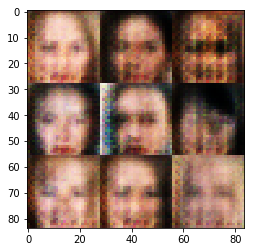

Epoch 1/1... Discriminator Loss: 0.8049... Generator Loss: 1.1840
Epoch 1/1... Discriminator Loss: 0.7897... Generator Loss: 1.1312
Epoch 1/1... Discriminator Loss: 0.8788... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 0.6514... Generator Loss: 1.3297
Epoch 1/1... Discriminator Loss: 0.9164... Generator Loss: 0.9228
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 0.8421... Generator Loss: 0.8814
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.6324... Generator Loss: 0.3036
Epoch 1/1... Discriminator Loss: 0.8474... Generator Loss: 1.2838


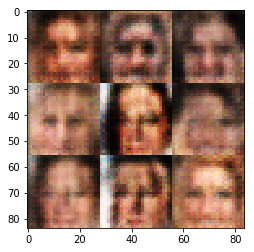

Epoch 1/1... Discriminator Loss: 0.7138... Generator Loss: 1.4322
Epoch 1/1... Discriminator Loss: 0.7166... Generator Loss: 1.2495
Epoch 1/1... Discriminator Loss: 0.8208... Generator Loss: 1.6596
Epoch 1/1... Discriminator Loss: 1.0475... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 0.8994... Generator Loss: 1.0572
Epoch 1/1... Discriminator Loss: 1.0452... Generator Loss: 0.9981
Epoch 1/1... Discriminator Loss: 0.9861... Generator Loss: 0.9461
Epoch 1/1... Discriminator Loss: 0.9308... Generator Loss: 1.1814
Epoch 1/1... Discriminator Loss: 0.7751... Generator Loss: 1.6786
Epoch 1/1... Discriminator Loss: 0.9119... Generator Loss: 1.5640


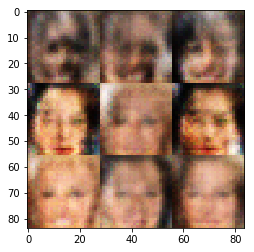

Epoch 1/1... Discriminator Loss: 0.8654... Generator Loss: 0.9621
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 0.9690... Generator Loss: 0.9348
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.3955
Epoch 1/1... Discriminator Loss: 0.9463... Generator Loss: 1.6000
Epoch 1/1... Discriminator Loss: 1.0384... Generator Loss: 0.9032
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 0.4599
Epoch 1/1... Discriminator Loss: 0.8463... Generator Loss: 1.6867
Epoch 1/1... Discriminator Loss: 0.9590... Generator Loss: 0.9545
Epoch 1/1... Discriminator Loss: 0.9654... Generator Loss: 1.3822


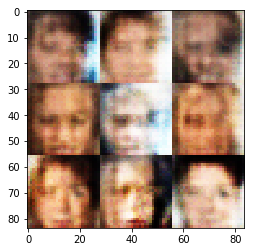

Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 1.7217
Epoch 1/1... Discriminator Loss: 1.0652... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 0.9924... Generator Loss: 1.0831
Epoch 1/1... Discriminator Loss: 1.0302... Generator Loss: 1.1039
Epoch 1/1... Discriminator Loss: 1.0325... Generator Loss: 0.9148
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 1.7595
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 1.6074
Epoch 1/1... Discriminator Loss: 0.9275... Generator Loss: 0.9587
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 2.1861
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 0.9906


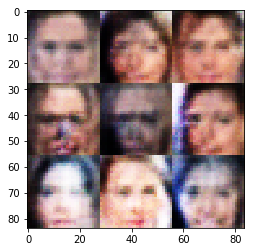

Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 0.9171
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 1.8485
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 0.9706... Generator Loss: 1.2857
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 1.2085
Epoch 1/1... Discriminator Loss: 1.1813... Generator Loss: 1.2143
Epoch 1/1... Discriminator Loss: 0.8451... Generator Loss: 1.3086
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 0.6322


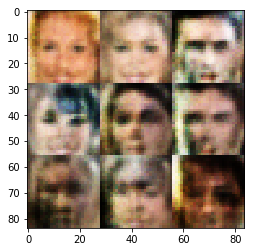

Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 0.9674... Generator Loss: 1.1856
Epoch 1/1... Discriminator Loss: 0.8148... Generator Loss: 1.2968
Epoch 1/1... Discriminator Loss: 1.1203... Generator Loss: 1.4151
Epoch 1/1... Discriminator Loss: 0.9500... Generator Loss: 1.0048
Epoch 1/1... Discriminator Loss: 0.9012... Generator Loss: 1.2946
Epoch 1/1... Discriminator Loss: 0.9718... Generator Loss: 1.5984
Epoch 1/1... Discriminator Loss: 0.9528... Generator Loss: 0.9916
Epoch 1/1... Discriminator Loss: 1.0456... Generator Loss: 1.2105
Epoch 1/1... Discriminator Loss: 0.9413... Generator Loss: 1.6981


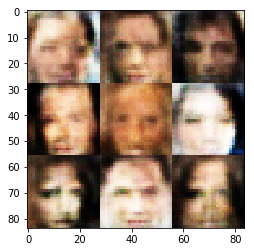

Epoch 1/1... Discriminator Loss: 0.9983... Generator Loss: 1.2303
Epoch 1/1... Discriminator Loss: 1.5235... Generator Loss: 3.1441
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.4695
Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 0.8978
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 2.1464
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 1.3675
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.5869
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.3952
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 1.1536
Epoch 1/1... Discriminator Loss: 1.0174... Generator Loss: 1.5152


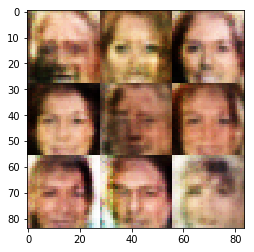

Epoch 1/1... Discriminator Loss: 1.0438... Generator Loss: 1.2719
Epoch 1/1... Discriminator Loss: 0.8921... Generator Loss: 1.0058


In [82]:
batch_size = 100
z_dim = 60
learning_rate = .0001
beta1 = .5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.